### Importing the Libraries

In [1]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore") 
# CUSTOMARY IMPORTS
import torch
from torch import nn
import torchvision
from  torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

# TRAINING HYPERPARAMETERS: 
n_epochs = 5           # How many passes through the training data  
batch_size = 64  # Training batch size usually in [1,256]

learning_rate = 5e-5   # Learning rate for optimizer like SGD usually in [0.001, 0.1]

random_seed = 1  

torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load and transform datasets

In [2]:
import torchvision
#Loading the dataset and preprocessing
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
validationset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Exploring Images

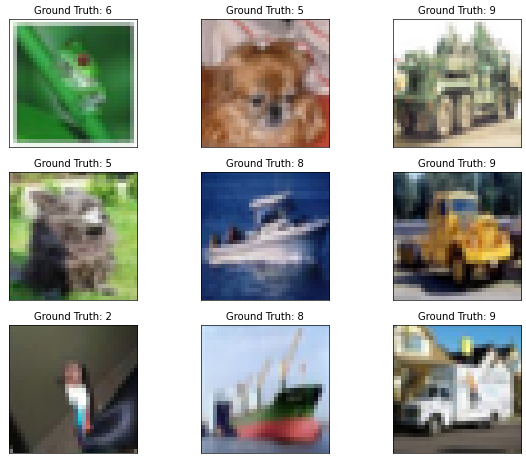

In [3]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = testset,
                                           batch_size = batch_size,
                                           shuffle = True)

examples = enumerate(test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig = plt.figure(figsize=(10, 8), dpi=60)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  temp_image = np.zeros((32, 32, 3))
  for row in range(32):
      for col in range(32):
          for chan in range(3):
              temp_image[row, col, chan] = example_X[i][chan][row][col]
  plt.imshow((temp_image + 1) / 2)
  plt.title("Ground Truth: {}".format(example_y[i]))
  plt.xticks([])
  plt.yticks([])


### Define NetWork

In [4]:

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)
        
        return x


net = ResNet().to(device)
print(net)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [5]:
params = list(net.parameters())
print(len(params)) # contains weights and bias
print(params[0].size()) # conv1's weight
print(params[1].size()) # conv1's bias

34
torch.Size([64, 3, 3, 3])
torch.Size([64])


### Optimizer & Loss Function

In [6]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters())
optimizer = optim.Adam(net.parameters(), lr=learning_rate, amsgrad=True)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

### Train the Model

In [7]:
from tqdm import tqdm

#存储训练过程
history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}

for epoch in range(1, n_epochs + 1):
    #构建tqdm进度条
    processBar = tqdm(train_loader,unit = 'step')
    #打开网络的训练模式
    net.train(True)
    #开始对训练集的DataLoader进行迭代
    totalTrainLoss = 0.0
   
    for step,(trainImgs,labels) in enumerate(processBar):
        
        #将图像和标签传输进device中
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)
        
        #清空模型的梯度
        optimizer.zero_grad()
        
        #对模型进行前向推理
        outputs = net(trainImgs)
        
        #计算本轮推理的Loss值
        loss = criterion(outputs,labels)
        #计算本轮推理的准确率
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        
        #进行反向传播求出模型参数的梯度
        loss.backward()
        #使用迭代器更新模型权重
        optimizer.step()

        #将本step结果进行可视化处理
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                    (epoch,n_epochs,loss.item(),accuracy.item()))

        totalTrainLoss+= loss
        
        if step == len(processBar)-1:
            with torch.no_grad():
                correct,totalLoss = 0,0
                totalSize = 0
                net.train(False)
                for testImgs,labels in test_loader:
                    testImgs = testImgs.to(device)
                    labels = labels.to(device)
                    outputs = net(testImgs)
                    loss = criterion(outputs,labels)
                    predictions = torch.argmax(outputs,dim = 1)
                    totalSize += labels.size(0)
                    totalLoss += loss
                    correct += torch.sum(predictions == labels)
                testAccuracy = correct/totalSize
                testLoss = totalLoss/len(test_loader)
                trainLoss = totalTrainLoss/len(train_loader)
                history['Train Loss'].append(trainLoss.item())
                history['Test Loss'].append(testLoss.item())
                history['Test Accuracy'].append(testAccuracy.item())
                processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                    (epoch,n_epochs,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()

[1/5] Loss: 0.8223, Acc: 0.5625, Test Loss: 0.9562, Test Acc: 0.6618: 100%|██████████| 782/782 [13:56<00:00,  1.07s/step]
[2/5] Loss: 0.8938, Acc: 0.6875, Test Loss: 0.7874, Test Acc: 0.7260: 100%|██████████| 782/782 [14:12<00:00,  1.09s/step]
[3/5] Loss: 0.9670, Acc: 0.8750, Test Loss: 0.7205, Test Acc: 0.7476: 100%|██████████| 782/782 [14:16<00:00,  1.10s/step]
[4/5] Loss: 0.6573, Acc: 0.8750, Test Loss: 0.6337, Test Acc: 0.7753: 100%|██████████| 782/782 [1:18:27<00:00,  6.02s/step]
[5/5] Loss: 0.1848, Acc: 0.6875, Test Loss: 0.5475, Test Acc: 0.8091: 100%|██████████| 782/782 [17:24<00:00,  1.34s/step]
